ref: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/tree/master/6.CHATBOT

##관련 경로 세팅##

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
# 훈련 데이터, 데이터 로더, 파이썬 파일 등을 불러오기 위해 경로 설정
import sys
sys.path.append('gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer')

In [3]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 11.9MB/s 
     |████████████████████████████████| 460kB 35.5MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


##모듈 불러오기##

In [4]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from PreprocessForTransformer import *

학습 데이터 경로 정의

In [5]:
BASE_PATH = '/content/gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer'
DATA_IN_PATH = BASE_PATH + '/data_in/'
DATA_OUT_PATH = BASE_PATH + '/data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [7]:
#시각화 함수
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [8]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

##모델 하이퍼파라미터 정의##

In [9]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 64
MAX_SEQUENCE = 25
EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1}

##모델 정의##

**패딩 및 포워드 마스킹**

In [10]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :] #(배치사이즈, 1, 1, 시퀀스 길이)

In [11]:
def create_look_ahead_mask(size):
  # tf.linalg.bad_part 함수를 통해 하각 삼각 행렬(대각을 기준으로 위쪽 성분이 모두 0)을 만든다
  # size를 4라고 치면
  # 1 0 0 0
  # 1 1 0 0
  # 1 1 1 0
  # 1 1 1 1
  
  # tf.ones 함수를 통해 모든 값이 1인 행렬을 만든다
  # 대각선 아래 영역은 1로 세팅, 위 영역은 0으로 세팅
  # 상수 1 - 매트릭스
  # 마스킹 해야 할 영역은 값이 1로 되고, 마스킹이 아닌 영역은  1 - (1) = 0
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [12]:
create_look_ahead_mask(4)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]], dtype=float32)>

In [13]:
def create_masks(inp, tar):#인풋, 타겟
  #인코더 패딩 마스크
  enc_padding_mask = create_padding_mask(inp)

  dec_padding_mask = create_padding_mask(inp)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [14]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

In [15]:
enc_padding_mask[1:5]

<tf.Tensor: shape=(4, 1, 1, 25), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


       [[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


       [[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


       [[[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)>

In [16]:
look_ahead_mask[1:5]

<tf.Tensor: shape=(4, 1, 25, 25), dtype=float32, numpy=
array([[[[0., 1., 1., ..., 1., 1., 1.],
         [0., 0., 1., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 1., 1., ..., 1., 1., 1.],
         [0., 0., 1., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 1., 1., ..., 1., 1., 1.],
         [0., 0., 1., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 1., 1., ..., 1., 1., 1.],
         [0., 0., 1., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 1., 1., 1

In [17]:
dec_padding_mask[1:5]

<tf.Tensor: shape=(4, 1, 1, 25), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


       [[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


       [[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


       [[[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)>

**포지셔널 인코딩**

In [18]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
  return pos * angle_rates

In [19]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # 피처 인덱스가 짝수인 경우 array에 sin 함수를 적용
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # 피쳐 인덱스가 홀수인 경우 인덱스를 가진 array에 cos 함수를 적용
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


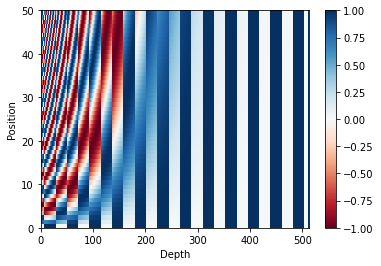

In [20]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

**어텐션**

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

**멀티헤드 어텐션**

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, **kargs):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = kargs['num_heads'] # 어텐션 헤드 수를 정의하는 파라미터
    self.d_model = kargs['d_model'] #k,q,v에 대한 차원 정의를 위한 파라미터

    #d_model 차원 수는 헤드 개수만큼 나누어져야 한다. 나머지 발생하면 안됨. 에러 체크 로직
    assert self.d_model % self.num_heads == 0

    # 차원수를 헤드 숫자로 나누어서 깊이를 정한다. 
    self.depth = self.d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(kargs['d_model']) #스케일 내적 연산 이전의 query에 대한 차원 수 맞추는 레이어
    self.wk = tf.keras.layers.Dense(kargs['d_model']) #스케일 내적 연산 이전의 key에 대한 차원 수 맞추는 레이어
    self.wv = tf.keras.layers.Dense(kargs['d_model']) #스케일 내적 연산 이전의 value에 대한 차원 수 맞추는 레이어
    self.dense = tf.keras.layers.Dense(kargs['d_model']) #셀프 어텐션 레이어

  def split_heads(self, x, batch_size):
    # 키 쿼리 벨류에 대한 벡터를 헤드 수만큼 분리할 수 있게 하는 함수이다.
    # [배치차원 X 시퀀스차원 X 피처차원] 벡터를 --> [배치차원 X 시퀀스차원 X 헤드차원 X 피처 차원] 으로 변환
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q) #(batch_size, seq_len, d_model)
    k = self.wk(k) #(batch_size, seq_len, d_model)
    v = self.wv(v) #(batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_q, depth)
    v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_q, depth)

    # scaled_attention.shape ==
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    # --> 여러 개의 헤드 피처에 대한 어텐션이 적용된 벡터를 얻은 상태
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
    output = self.dense(concat_attention)
    return output, attention_weights

**포지션 와이즈 피드포워드 네트워크**

In [23]:
def point_wise_feed_forward_network(**kargs):
  return tf.keras.Sequential([
    tf.keras.layers.Dense(kargs['dff'], activation='relu'), #(batch_size, seq_len, dff)
    tf.keras.layers.Dense(kargs['d_model']) #(batch_size, seq_len, d_model)
  ])

**인코더 레이어**

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [25]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, **kargs):
    super(Encoder, self).__init__()

    self.d_model = kargs['d_model'] #워드 임베딩 및 포지션 임베딩 차원수를 결정
    self.num_layers = kargs['num_layers'] #인코더 레이어 수

    self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model) #워드 임베딩 사전 수
    self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model) #포지션 인코더 최대 길이 지정
    self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]# 레이어 개수만큼 인코더 레이어 생성
    self.dropout = tf.keras.layers.Dropout(kargs['rate'])# 드롭아웃 레이어 생성

  def call(self, x, mask):
    seq_len = tf.shape(x)[1] #입력 벡터에 대한 시퀀스 길이 받고
    x = self.embedding(x) #워드 임베딩 할당 받고
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #스케일 처리
    x += self.pos_encoding[:, :seq_len, :] #포지션 임베딩 값 더하고
    x = self.dropout(x) #드롭아웃 적용

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, mask)

    return x

**디코더 레이어**

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, **kargs):
    super(Decoder, self).__init__()

    self.d_model = kargs['d_model'] #워드 임베딩 및 포지션 임베딩 차원수 결정
    self.num_layers = kargs['num_layers'] #인코더 레이어 수

    self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)#워드 임베딩 사전 수
    self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)#포지션인코더 최대 길이
    self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]#레이어 개수만큼 디코더 레이어 생성
    self.dropout = tf.keras.layers.Dropout(kargs['rate'])#드롭아웃 레이어 생성

  def call(self, x, enc_output, look_ahead_mask, padding_mask):
    seq_len = tf.shape(x)[1]#입력 벡터에 대한 시퀀스 길이 할당
    attention_weights = {}#어텐션 웨이트 딕셔너리 설정

    x = self.embedding(x)#워드 임베딩 할당
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))#스케일 처리
    x += self.pos_encoding[:, :seq_len, :]#포지션 임베딩 값 더하고
    x = self.dropout(x)#드롭아웃 적용

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_black2'.format(i+1)] = block2

    return x, attention_weights

##트랜스포머 모델##

In [47]:
class Transformer(tf.keras.Model):
  def __init__(self, **kargs):
    super(Transformer, self).__init__(name=kargs['model_name'])
    self.end_token_idx = kargs['end_token_idx'] #마지막 end_token에 대한 인덱스 값을 저장하는 클래스 멤버 변수
                                                # inference 함수에서 end_token 이후로는 더 이상 모델 추론을 하지 않음
    self.encoder = Encoder(**kargs) #인코더 레이어 선언
    self.decoder = Decoder(**kargs) #디코더 레이어 선언
    self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size']) #피드 포워드 레이어 선언
  
  #call함수 : 학습할 때 활용됨
  def call(self, x):
    inp, tar = x #인코더에 입력될 값 + 디코더에 입력될 값 -> x / inp:인코더 입력, tar:디코더 입력
    
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar) #마스크 값 받아오기
    enc_output = self.encoder(inp, enc_padding_mask)
    
    dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)
    
    return final_output

  #inference함수 : 입력 텍스트에 대해 모델을 추론할 때 사용 됨
  def inference(self, x):
    inp = x # call 함수와 다름
    #디코더에 입력할 시퀀스를 주지 않는다. 시작 토큰 STD만 주고 다음 다음 토큰을 생성 해야 한다
    tar = tf.expand_dims([STD_INDEX], 0) 

    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
    enc_output = self.encoder(inp, enc_padding_mask)

    predict_tokens = list()
    for t in range(0, MAX_SEQUENCE):
      dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)
      outputs = tf.argmax(final_output, -1).numpy()
      pred_token = outputs[0][-1]
      if pred_token == self.end_token_idx:
        break
      predict_tokens.append(pred_token)
      tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0) # 디코더의 입력으로 들어갈 다음 토큰 차원 확대
      _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
    
    return predict_tokens


##모델 로스 정의##

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [49]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[accuracy])

In [50]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer/data_out/transformer -- Folder already exists 



In [51]:
history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
167/167 [==============================] - ETA: 0s - loss: 1.6129 - accuracy: 0.8098
Epoch 00001: val_accuracy improved from -inf to 0.80742, saving model to /content/gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer/data_out/transformer/weights.h5
167/167 [==============================] - 33s 197ms/step - loss: 1.6129 - accuracy: 0.8098 - val_loss: 1.6903 - val_accuracy: 0.8074
Epoch 2/5
167/167 [==============================] - ETA: 0s - loss: 1.3559 - accuracy: 0.8089
Epoch 00002: val_accuracy improved from 0.80742 to 0.81066, saving model to /content/gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer/data_out/transformer/weights.h5
167/167 [==============================] - 33s 197ms/step - loss: 1.3559 - accuracy: 0.8089 - val_loss: 1.5976 - val_accuracy: 0.8107
Epoch 3/5
167/167 [==============================] - ETA: 0s - loss: 1.2249 - accuracy: 0.8136
Epoch 00003: val_accuracy improved from 0.81066 to 0.81630, saving model to /content/gdrive/My Dri

In [52]:

model.save(filepath = '/content/gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer/data_out/transformer/', save_format="tf")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer/data_out/transformer/assets


##베스트 모델 불러오기##

In [53]:
SAVE_FILE_NM = "weights.h5"
print(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

/content/gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_transformer/data_out/transformer/weights.h5


In [54]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [55]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [57]:
text = "오늘 시험을 망쳤어"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

잘 할수있을거예요
